In [1]:
import requests
import json
import time
from datetime import date
from datetime import datetime
from helpers.history_fetcher import HistoryFetcher
import dateutil.parser
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gdelt # pip install gdelt
import folium
import os
from tqdm import tqdm_notebook # conda install tqdm
import operator
from helpers.wiki_helpers import get_stability_for_country, make_folium_map, wiki_change_factor

import warnings
warnings.filterwarnings('ignore')

import itertools

%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None

### Gather GDELT data
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
### this code is executed on the big server to obtain the results from 2011 to 2018 divided into 3 files per year
### for size.

import numpy as np
import pandas as pd
import gdelt # pip install gdelt
import gc

gd1 = gdelt.gdelt(version=1)
for i in range(11, 18):
    print('year : ', i , 1)
    results = gd1.Search(['20'+str(i)+' January 01','20'+str(i)+' May 01'],table='events')
    cols_to_keep = ['SQLDATE','ActionGeo_CountryCode','ActionGeo_Type' ]
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_1.pckl')
    del results
    gc.collect()
    print('year : ', i , 2)
    results = gd1.Search(['20'+str(i)+' May 01','20'+str(i)+' August 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_2.pckl')
    del results
    gc.collect()
    print('year : ', i , 3)
    if(i != 17):
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i+1)+' January 01'],table='events')
    else:
        results = gd1.Search(['20'+str(i)+' August 01','20'+str(i)+' December 01'],table='events')
    results = results[cols_to_keep]
    pd.to_pickle(results, 'gdelt_filtered_20'+str(i)+'_3.pckl')
    del results
    gc.collect()

### Process GDELT Data (aggregate) 
#### EXECUTE ONLY ON THE SERVER (memory issues)

In [ ]:
from os import listdir
from os.path import isfile, join
import gc

def process_files():
    onlyfiles = [f for f in listdir('.') if isfile(join('.', f))]
    
    grouped = pd.DataFrame()
    for i, file in enumerate(onlyfiles):
        print('processing ', file)
        gc.collect()
        try:
            data = pd.read_pickle(file)
            data['Counter'] = 1.0
            data = data[['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type', 'Counter']]
        except:
            continue;
        grouped = grouped.append([data.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()])
        pd.to_pickle(grouped, 'processed/'+str(i)+'.pckl')
        del data

### Show the gathered data

In [3]:
CAMEO_event_dic = {1:'MAKE PUBLIC STATEMENT', 
                   2:'APPEAL', 
                   3:'EXPRESS INTENT TO COOPERATE', 
                   4:'CONSULT', 
                   5:'ENGAGE IN DIPLOMATIC COOPERATION', 
                   np.NaN:'',
                   0:'UNKNOWN'}


aggregated_gdelt = pd.read_pickle('data/23.pckl')
# clean the dataframe
aggregated_gdelt.reset_index(inplace=True)
# change names
aggregated_gdelt['ActionGeo_Type'] = aggregated_gdelt['ActionGeo_Type'].map(CAMEO_event_dic)
aggregated_gdelt.sort_values('SQLDATE', inplace=True)
# take only values above 2011
aggregated_gdelt = aggregated_gdelt[aggregated_gdelt['SQLDATE'] > 20110101]
# convert to Timestamp (takes lots of time)
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: str(x) )
aggregated_gdelt['SQLDATE'] = aggregated_gdelt['SQLDATE'].apply(lambda x: pd.Timestamp(x).to_pydatetime())
pd.to_pickle(aggregated_gdelt, 'data/aggregated_gdelt.pckl')
aggregated_gdelt.head(20)

,SQLDATE,ActionGeo_CountryCode,ActionGeo_Type,Counter
148228,2011-01-02,RQ,MAKE PUBLIC STATEMENT,82.0
148190,2011-01-02,OC,UNKNOWN,1.0
148189,2011-01-02,NZ,ENGAGE IN DIPLOMATIC COOPERATION,7.0
148188,2011-01-02,NZ,CONSULT,165.0
148187,2011-01-02,NZ,MAKE PUBLIC STATEMENT,72.0
148186,2011-01-02,NZ,UNKNOWN,2.0
148185,2011-01-02,NU,CONSULT,1.0
148184,2011-01-02,NU,MAKE PUBLIC STATEMENT,6.0
148183,2011-01-02,NU,UNKNOWN,1.0
148182,2011-01-02,NS,CONSULT,2.0


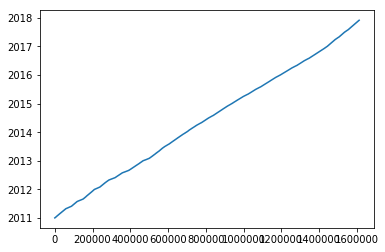

In [4]:
aggregated_gdelt = pd.read_pickle('data/aggregated_gdelt.pckl')

dates = aggregated_gdelt['SQLDATE'].values
cntr_codes = aggregated_gdelt['ActionGeo_CountryCode'].values
types = aggregated_gdelt['ActionGeo_Type'].values


plt.plot(sorted(dates))
plt.show()

In [25]:
from scipy.stats.stats import pearsonr

def get_country_values(cntr_code, start, stop, normalize=True):
    values_to_plot = aggregated_gdelt[ (aggregated_gdelt['ActionGeo_CountryCode'] == cntr_code) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) >= pd.Timestamp(start)) &
                                     ((aggregated_gdelt['SQLDATE']).astype(pd.Timestamp) <= pd.Timestamp(stop))];
    values_to_plot['ActionGeo_Type'] = 0;
    values_to_plot.groupby(['SQLDATE','ActionGeo_CountryCode', 'ActionGeo_Type']).sum()
    values_to_plot.reset_index(inplace=True)
    if(normalize):
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']/ values_to_plot['Counter'].mean()
    else:
        x = values_to_plot['SQLDATE']
        y = values_to_plot['Counter']
    return x.values,y.values

def analyse_wiki_events_correlation(country_code, country_name, date_start, date_stop, plot=False):
    history_fetcher = HistoryFetcher(country_name)
    response = history_fetcher.get_history(date_start, date_stop)

    # Keeps only the date field for each edit
    fr_edits_dates = list(map(lambda revision: revision['timestamp'], response))
    plt.figure(figsize=(15,7))
    
    bins_nr = int( (pd.Timestamp(date_stop) - pd.Timestamp(date_start) ).days/30.5  ) # 1mo per bar

    # Add historgram for the number of edits on ukraine's wikipedia page (normalized)
    n_wiki, bins_wiki, patches_wiki = plt.hist(fr_edits_dates,\
                                               bins=bins_nr,\
                                               normed=True,\
                                               color='blue',\
                                               alpha=0.5,\
                                               label='# of wiki edits '+country_name)
    
    plt.hold(True)

    fr_events_dates, w = get_country_values(country_code , date_start, date_stop)
    # Add histogram for the number of events (normalized)s
    n_event, bins_event, patches_event = plt.hist(fr_events_dates,\
                                                  weights=w,
                                                  bins=bins_nr,\
                                                  color='green',\
                                                  normed=True,\
                                                  alpha=0.5,\
                                                  label='# events ' + country_name)

    if(plot == True):
        plt.xticks(rotation=45)
        plt.xlabel('Time in months')
        plt.ylabel('Normalized number of edits/events')
        plt.legend(loc='upper right')
        plt.title('Nr of Wiki Edits and GDELT Events for ' + country_name)
        plt.show()
        
    corr, non_sureness = pearsonr(n_event, n_wiki)
    
    return np.abs(corr), (1-non_sureness)
    

In [26]:
countries_data = pd.read_pickle('countries_data.pckl')
countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita,stab to plot,Stability Truncated,Perason Wiki/GDELT Events
0,533,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.661227,93.328354,0.0,26005.409405,247.049413,0.988417,1.000000,0.035040
1,028,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.200000,66.511824,0.0,14764.489509,144.732870,0.949338,1.000000,0.302105
2,784,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.243406,8577.012446,1.0,40438.771500,4.301931,0.674155,0.471846,NaN
3,004,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.260000,2934.784691,1.0,623.184798,0.017540,0.000000,0.000000,0.089826
4,012,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.200000,15783.530244,1.0,4154.118319,0.100540,0.773680,0.665484,0.492696


In [31]:
### fethcing all the data()

countries_data = pd.read_pickle('countries_data.pckl')
countries_data

#countries_data['Perason Wiki/GDELT Events mo *sur'] = np.NaN

for i, cntr_code in enumerate(sorted(list(set(cntr_codes)))):
    pd.to_pickle(countries_data,'countries_data.pckl')
    try:
        prev_val = countries_data[countries_data['FIPS']==cntr_code]['Perason Wiki/GDELT Events mo *sur'].values[0]
    except:
        continue
    if str(prev_val).upper() == 'NAN':
        
        name = countries_data[countries_data['FIPS']==cntr_code]['Country'].values
        if(len(name) == 0):
            print('Processing ', cntr_code, 'NO CODE FOUND')

        print('Processing ', cntr_code, '-', name[0])

        if  len(str(name[0])) > 3:
            corr, sureness = analyse_wiki_events_correlation(cntr_code,name[0],'20110101000000', '20171215000000');
            countries_data.ix[countries_data['FIPS']==cntr_code,'Perason Wiki/GDELT Events mo *sur'] = corr * sureness ;
            print('Processed ', name[0] , 'corr : ', corr * sureness)

        else:
            print('Processed ', cntr_code , ' NaN CODE ')
    else:
        print(cntr_code,'Already processed.')
        
        
        

Processing  AA - Aruba
Processed  Aruba corr :  0.00297966381665
Processing  AC - Antigua and Barbuda
Processed  Antigua and Barbuda corr :  0.244411343431
Processing  AE - United Arab Emirates
Processed  United Arab Emirates corr :  0.0230502608718
Processing  AF - Afghanistan
Processed  Afghanistan corr :  0.15006895486
Processing  AG - Algeria
Processed  Algeria corr :  0.512626335958
Processing  AJ - Azerbaijan
Processed  Azerbaijan corr :  0.144147357664
Processing  AL - Albania
Processed  Albania corr :  0.0437615519295
Processing  AM - Armenia
Processed  Armenia corr :  0.000452808221881
Processing  AN - Andorra
Processed  Andorra corr :  0.0558129880402
Processing  AO - Angola
Processed  Angola corr :  0.220731012676
Processing  AR - Argentina
Processed  Argentina corr :  0.00176887707684
Processing  AS - Australia
Processed  Australia corr :  0.215757339925
Processing  AU - Austria
Processed  Austria corr :  0.190185443348
Processing  AV - nan
Processed  AV  NaN CODE 
Processi

Processed  Nicaragua corr :  0.140946181869
Processing  NZ - New Zealand
Processed  New Zealand corr :  0.103000339137
Processing  PA - Paraguay
Processed  Paraguay corr :  0.0803739268951
Processing  PE - Peru
Processed  Peru corr :  0.470972845416
Processing  PK - Pakistan
Processed  Pakistan corr :  0.0872624420383
Processing  PL - Poland
Processed  Poland corr :  0.37415325838
Processing  PM - Panama
Processed  Panama corr :  0.000231725465687
Processing  PO - Portugal
Processed  Portugal corr :  0.253703226538
Processing  PP - Papua New Guinea
Processed  Papua New Guinea corr :  0.304630708834
Processing  PU - Guinea-Bissau
Processed  Guinea-Bissau corr :  0.361201569268
Processing  QA - Qatar
Processed  Qatar corr :  0.0339311480135
Processing  RM - Marshall Islands
Processed  Marshall Islands corr :  0.041244309376
Processing  RO - Romania
Processed  Romania corr :  0.339121545976
Processing  RP - Philippines
Processed  Philippines corr :  0.280969747587
Processing  RQ - Puerto 

In [33]:
pd.to_pickle(countries_data,'countries_data.pckl')
countries_data.head()

,Code numeric,FIPS,Code,Country,Region,Wiki Stability MLE,Wiki Instability old,Wiki mean change day,Population[k],Internet Users%,Internet users[k],Big Internet,GDP,GDP per capita,stab to plot,Stability Truncated,Perason Wiki/GDELT Events,Perason Wiki/GDELT Events mo *sur
0,533,AA,ABW,Aruba,Americas,2.400000,0.023033,0.354108,105.264,88.661227,93.328354,0.0,26005.409405,247.049413,0.988417,1.000000,0.035040,0.002980
1,028,AC,ATG,Antigua and Barbuda,Americas,3.303965,0.098758,0.257224,102.012,65.200000,66.511824,0.0,14764.489509,144.732870,0.949338,1.000000,0.302105,0.244411
2,784,AE,ARE,United Arab Emirates,Asia,0.471846,0.036796,1.801133,9400.145,91.243406,8577.012446,1.0,40438.771500,4.301931,0.674155,0.471846,NaN,0.023050
3,004,AF,AFG,Afghanistan,Asia,0.000000,0.000000,0.000000,35530.081,8.260000,2934.784691,1.0,623.184798,0.017540,0.000000,0.000000,0.089826,0.150069
4,012,AG,DZA,Algeria,Africa,0.665484,0.100532,1.277054,41318.142,38.200000,15783.530244,1.0,4154.118319,0.100540,0.773680,0.665484,0.492696,0.512626
